In [34]:
import itertools
import datetime
import numpy as np 
import pandas as pd 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from pylab import rcParams
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()
import warnings 

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18,8
warnings.filterwarnings('ignore')
%matplotlib inline

In [35]:
# !pip install cufflinks

In [36]:
def preprocess_data():
    df = pd.read_excel('./datasets/Charges_and_Payments_Datascience_1.xlsx')
    df = df.loc[2:]
    df.drop(columns='Unnamed: 9', axis=1, inplace=True)
#     df.dropna(axis=1, inplace=True)
    new_cols = [str(col).replace('2029', '2019').replace(" 00:00:00", '').replace('-', '') \
                .replace('.','_').replace(' ','_').lower() \
                for col in df.iloc[0]]
    
    for index, col in enumerate(new_cols):
        if col == '2019-01-01 00:00:00':
            print(index)
    
    df.drop(df.index[0], inplace=True)
    
    df = df.rename(columns={key:value for key, value in zip(df.columns, new_cols)})
    df = df[df['status'] == 'Active']
    print(len(df.columns))
    pd.set_option('display.max_columns', 55)
    
    df.set_index('practice_name', inplace=True)
    
    return df

d_ = preprocess_data()

d_.head()

54


,lookup,code,sub_division,platform,status,speciality,team_lead,manager_ops,20190131,20190228,20190330,20190429,20190530,20190629,20190730,20190830,20190929,20191030,20191129,20191229,20200101,20200201,20200301,20200401,20200502,20200602,20200703,20200803,20200903,20201001,nan,20190101,20190201,20190303,20190402,20190502,20190602,20190702,20200803,20200902,20201002,20201101,20201201,20200101,20200201,20200301,20200401,20200502,20200602,20200703,20200803,20200902,20201002
practice_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"MEHNAZ A. HAQ, MD, LLC",1,100,MTBC,MIS,Active,Internal Medicine,EFFAT MUMTAZ,SHANZA RATHORE,69864.5,63023.8,60556,78107,70229,56616,85129,84093,111879,118749,90545,94158,76808,102929,67445,28352,20384,49083,81422,62543,71329.2,127292,NaN,26542.1,30210.7,26431,32573,40620,29547,25830,37219,36012,50592,39846,37208,26473,28739,33921,15068,17587,13612,27524,25653,25454.2,50756.4
ARTHRITIS CARE MEDICAL CENTER,1,111,MTBC,MIS,Active,Rheumatology,EFFAT MUMTAZ,SHANZA RATHORE,51174,61501,85927,110423,108966,113151,118745,121862,39311,39664,55412,51259,56654,51558,45563,37676,40462,49786,49890,41385,46442.4,53092.9,NaN,25048.9,23701.9,34471,43093,33921,27866,34720,33960,28864,31177,36254,38802,24459,29479,31568,35899,23577,27058,16903,31267,27365.5,33066.6
"ZAPANTA MEDICAL ASSOCIATES, INC",1,126,MTBC,MIS,Active,Otolaryngology,ABIDA KHANUM,SAMAN NOOR,5515.08,23402.3,32011,48253,36777,41838,61862,26038,65091,45948,41366,35358,55837,34351,54226,13787,26622,38530,28388,37432,28262.2,29549.3,NaN,7912.76,8864.5,13832,18295,16562,14467,13722,14557,10039,15668,14975,15964,7740,13478,12925,8094,4079,8843,12796,8799,10249.9,9791.99
"MONA E. YOUSEF, MD",1,133,MTBC,MIS,Active,Ob Gynecology,ZAHRA SYED,Asma Batool,27117,30595,4666,35139,37004,30290,40945,42804,27275,35493,31722,30410,26367,33790,27846,18971,16437,18553,24196,30286,25924,27997.2,NaN,10464,12570.8,7235,11441,15220,11502,14584,16345,13412,17723,14516,12649,7808,11940,11952,7915,7565,6786,10397,8625,9771.72,8478.42
"DANIELA TURACOVA, MD",2,138,MTBC,MIS,Active,Internal Medicine,AREEJ TARIQ,BENISH RAQEEB,160082,100110,102482,69000,92358,71780,128205,101326,87372,141414,108480,18394,130924,28754,128902,37272,55862,144247,-80,62483,61948,84215,NaN,56920.1,75523.6,41782,58861,59419,39144,56515,43777,46304,54560,65768,25409,35630,39824,20522,50133,18870,37346,40953,25561,24939.5,37241.8


In [37]:
def change_datetime(cols):
    return pd.to_datetime(cols, format='%Y%m%d')

def charges_payments_dataframe(d):
    chages_start_index = charges_end_index = payments_start_index = payments_end_index = nan_index = 0
    for index, col in enumerate(d.columns):
        if col == "20190131":
            charges_start_index = index
            
        elif col == "20201001":
            charges_end_index = index
            
        elif col == "20190101":
            payments_start_index = index 
            
        elif col == "20201002":
            payments_end_index = index 
        
        elif col == 'nan':
            nan_index = index 
            
        else:
            continue
        
    charges_df, payments_df = d.iloc[:, charges_start_index:charges_end_index+1], d.iloc[:, payments_start_index:payments_end_index+1]
    
    new_charges_cols, new_payments_cols = change_datetime(charges_df.columns), change_datetime(payments_df.columns)
#     print(new_charges_cols)
#     print(new_payments_cols)
    
#     charges_df.columns, payments_df.columns = new_charges_cols, new_payments_cols
    try:
        charges_df = charges_df.rename(columns={key:value for key, value in zip(charges_df.columns, new_charges_cols)})
        payments_df = payments_df.rename(columns={key:value for key, value in zip(payments_df.columns, new_payments_cols)})
    
    except Exception as e:
        print('Exception! ', e)
        
    return (charges_df.T.astype('float'), payments_df.T.astype('float'))
    
charges_df, payments_df = charges_payments_dataframe(d_)

In [38]:
payments_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2019-01-01 to 2020-10-02
Columns: 1074 entries, MEHNAZ A. HAQ, MD, LLC to Anesthesia Advantage Of Delaware  
dtypes: float64(1074)
memory usage: 184.8 KB


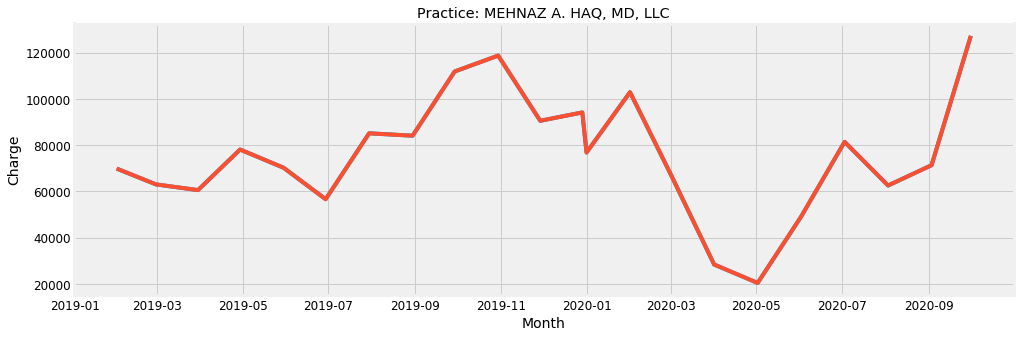

2019-01-31     69864.47
2019-02-28     63023.84
2019-03-30     60556.00
2019-04-29     78107.00
2019-05-30     70229.00
2019-06-29     56616.00
2019-07-30     85129.00
2019-08-30     84093.00
2019-09-29    111879.00
2019-10-30    118749.00
2019-11-29     90545.00
2019-12-29     94158.00
2020-01-01     76808.00
2020-02-01    102929.00
2020-03-01     67445.00
2020-04-01     28352.00
2020-05-02     20384.00
2020-06-02     49083.00
2020-07-03     81422.00
2020-08-03     62543.00
2020-09-03     71329.25
2020-10-01    127292.02
Name: MEHNAZ A. HAQ, MD, LLC, dtype: float64


In [39]:
plt.figure(figsize=(15,5))
plt.plot(charges_df['MEHNAZ A. HAQ, MD, LLC'])
plt.plot(charges_df['MEHNAZ A. HAQ, MD, LLC'])
plt.xlabel('Month')
plt.ylabel('Charge')
plt.title('Practice: ' +"MEHNAZ A. HAQ, MD, LLC")
plt.show()

print(charges_df['MEHNAZ A. HAQ, MD, LLC'])

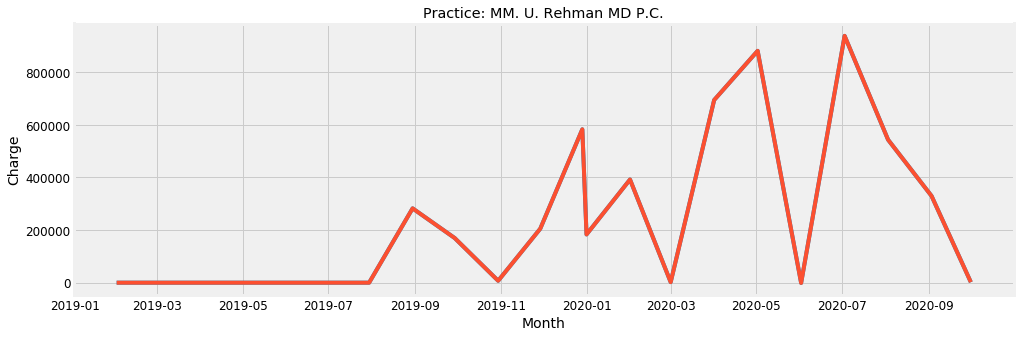

2019-01-31         0.0
2019-02-28         0.0
2019-03-30         0.0
2019-04-29         0.0
2019-05-30         0.0
2019-06-29         0.0
2019-07-30         0.0
2019-08-30    282569.0
2019-09-29    169770.0
2019-10-30      7320.0
2019-11-29    205141.0
2019-12-29    583209.0
2020-01-01    183424.0
2020-02-01    392256.0
2020-03-01      2074.0
2020-04-01    694535.0
2020-05-02    881469.0
2020-06-02      -986.0
2020-07-03    938501.0
2020-08-03    543536.0
2020-09-03    329667.0
2020-10-01      1957.0
Name: M. U. Rehman MD P.C., dtype: float64


In [40]:
plt.figure(figsize=(15,5))
plt.plot(charges_df['M. U. Rehman MD P.C.'])
plt.plot(charges_df['M. U. Rehman MD P.C.'])
plt.xlabel('Month')
plt.ylabel('Charge')
plt.title('Practice: ' +"MM. U. Rehman MD P.C.")
plt.show()

print(charges_df['M. U. Rehman MD P.C.'])

In [47]:
def time_series_forecast(practice):
    X = practice.values
    size = int(len(X) * 0.77)
    train, test = X[0:size], X[size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(2,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    plt.figure(figsize=(20,6))
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()

predicted=20663.031484, expected=17587.000000
predicted=19033.222945, expected=13612.000000
predicted=13576.811555, expected=27524.000000
predicted=22590.676937, expected=25653.000000
predicted=25202.381691, expected=25454.210000
predicted=25501.942703, expected=50756.420000
Test MSE: 146767592.838


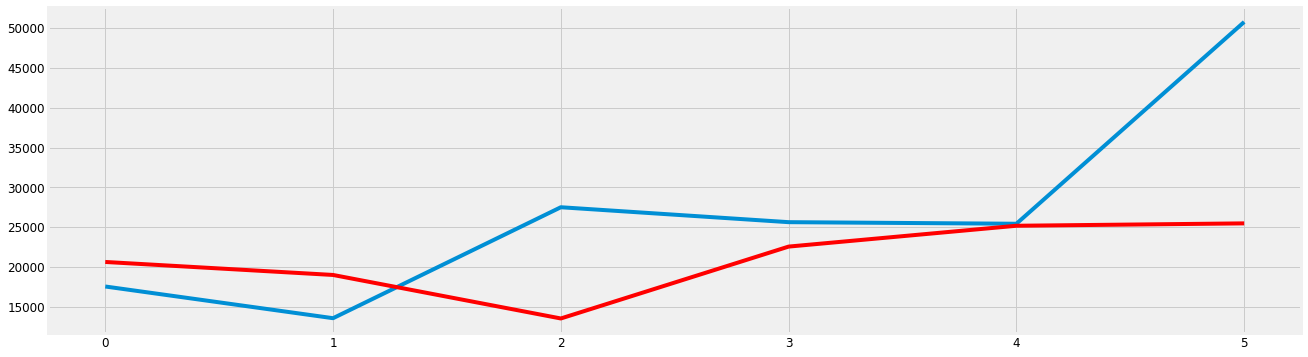

In [48]:
time_series_forecast(payments_df['MEHNAZ A. HAQ, MD, LLC'])

In [96]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = 0, 0
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(miss_haq_practice.values, p_values, d_values, q_values)

NameError: name 'miss_haq_practice' is not defined

In [170]:
# FEW IMPORTANT THINGS:

# 1- How to check if the Series is STATIONARY
# 2- How to check if the Series has Auto-correlation
# 3- What is ACF function?
# 4- What is Akaike Information Criterion? -> breifly it's used to determine the lag.
# 5- Find the Summary Statistics of the data, to check if the Series is Stationary!
# 6- Augmented Dickey Fuller test, for Stationary check!
# 7- Unit root check - presense shows the series is Non-stationary
# 8- Null Hypthesis ensures that unit root is present - Series Non-Stationary
# 9- Alternate Hypothesis ensures that unit root is not present - Series Stationary


In [71]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        self.pValue = adfTest[1]
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
        #Add Critical Values
        for key,value in adfTest[4].items():
            dfResults['Critical Value (%s)'%key] = value
        print('Augmented Dickey-Fuller Test Results:')
        print(dfResults)
        
        
def adf_stationarity_test(series, significance=0.05, print_result=True):
    is_stationary = None
    p_value = None
    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]
    
    if p_value < significance:
        is_stationary = True
    
    else:
        is_stationary = False
        
    if print_result:
        for i in adf_test[:4]:
            print(i)
        df_results = pd.Series(adf_test[:4],
                              index = ['adf_test_statistics', 'p_value', 'lags_used',
                                       'observations_used'])
        
#     add critical values 
    for key, value in adf_test[4].items():
        df_results['critical_value %s' %key] = value
        
    return df_results

In [75]:
st = StationarityTests()
st.ADF_Stationarity_Test(np.asarray(charges_df['M.C. HOTHEM DO P.A.']))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -0.104414
P-Value                  0.948997
# Lags Used              8.000000
# Observations Used     13.000000
Critical Value (1%)     -4.068854
Critical Value (5%)     -3.127149
Critical Value (10%)    -2.701730
dtype: float64


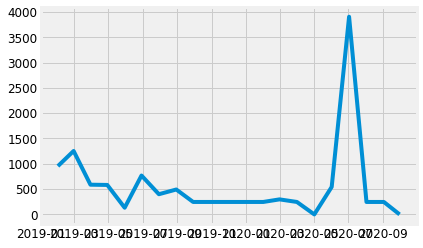

In [76]:
plt.plot(charges_df['M.C. HOTHEM DO P.A.'])

In [74]:
print(len(charges_df['MEHNAZ A. HAQ, MD, LLC']))

22


In [73]:
adf_stationarity_test(np.asarray(charges_df['M. U. Rehman MD P.C.']))

0.00988641188971533
0.9593420886745804
9
12


adf_test_statistics     0.009886
p_value                 0.959342
lags_used               9.000000
observations_used      12.000000
critical_value 1%      -4.137829
critical_value 5%      -3.154972
critical_value 10%     -2.714477
dtype: float64

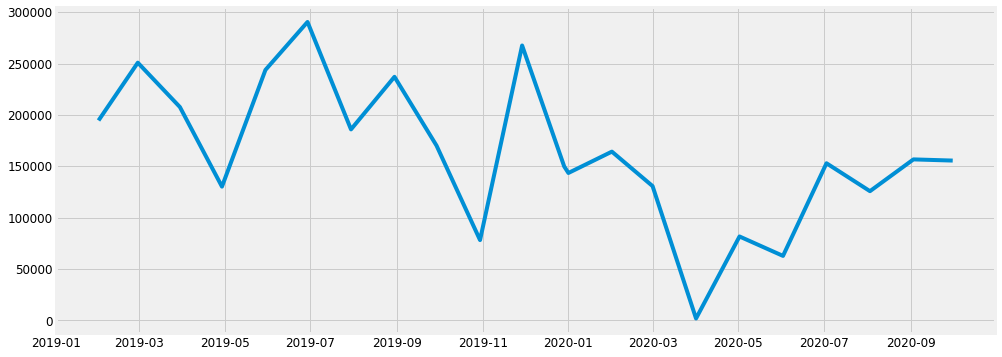

In [182]:
plt.figure(figsize=(15,6))
plt.plot(charges_df['M. JAY JAZAYERI, M.D. INC'])

In [188]:
charges_df[charges_df['M. JAY JAZAYERI, M.D. INC'] == 0]

practice_name,"MEHNAZ A. HAQ, MD, LLC",ARTHRITIS CARE MEDICAL CENTER,"ZAPANTA MEDICAL ASSOCIATES, INC","MONA E. YOUSEF, MD","DANIELA TURACOVA, MD","ALLA KATSEVA, MD","DOCTORS CARE ASSOCIATES, LLC","ROBERT M. SCHAEFER, MD, FACOG, PC","MADHU JAIN, MD","CHARLES TERRY, MD","KEVIN MCGUIGAN, MD","ROBYN F. AGRI, MD","FORD MEDICAL ASSOCIATES, PA",SEASHORE MEDICAL ASSOCIATES,"DAVID W. LEE, MD","CARING DOCTORS MEDICAL CENTER, PC","RABIA S. AWAN, MD",QUALITY FOOT CARE CENTER,"ELENA GUROVA, MD, PA","JOSEPH SHALIT, MD, PA","GRACE A. KOTHARI, MD",MEDICAL CARE CENTER OF LAKE VILLA,"CARL GINSBERG, DPM","NICOLETTE FILITIS, MD","DOSHI MEDICAL CENTER, LLC",BE WELL FAMILY PRACTICE,"MERCER OBGYN, PA",...,"PARKWAY ANESTHESIA, LLC",Comprehensive Pain Management,North Shore Ambulatory Anesthesia,"JEFFREY P. THOMPSEN, MD LLC",EYE DISEASE CONSULTANTS,Windsor Medical Associates,"Mandell & Blau, Mds","Aiken Regional Medical Centers, Inc",Hackettstown Anesthesia,Three Rivers Pain Management,MOREHOUSE SCHOOL OF MEDICINE,Consultants in Ambulatory Anesthesia,Anesthesia Specialists of NJ,"Kathleen E. Kearney, MD, PC",Office Based Anesthesia,"SHAWS COVE ORTHOPAEDICS, LLC",Gastrointestinal Associates of Rockland,Dr Anesthesia,"RA Pain Services, P.A.",Laurel Anesthesia Associates,First Hill Surg Ctr,Murphy Medical,Hutchinson ASC,Hutch Physicians PA,Spring Cove Medical Services,Advanced Ambultory Anesthesia,Anesthesia Advantage Of Delaware
